# Jul 21st, 2022 (Fig-2 OCs; K=7; p=25)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

## Fig dir

In [2]:
nn = 512
perc = 25
fig_dir = 'Fig2_OCs'
fig_dir = pjoin(fig_base_dir, 'paper2.0', f'n{nn}-p{perc}', fig_dir)
os.makedirs(fig_dir, exist_ok=True)
print(fig_dir)

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p25/Fig2_OCs

## Prepare (512)

In [3]:
num_k = 7
mice = Mice(nn)

## Results

In [4]:
final_perm={4: 5, 5: 4}
final_perm = {
    i: final_perm.get(i, i)
    for i in range(num_k)
}

In [5]:
%%time

results = similiarity_results(
    mice=mice,
    perc=perc,
    num_k=num_k,
    merge_thres=0.444,
    n_resamples=int(1e5),
    final_perm=final_perm,
)
bt = BootStrap(**results['props_ca'])
list(results)

CPU times: user 9min 14s, sys: 2min 19s, total: 11min 34s
Wall time: 12min 13s


[
    'bt_dict',
    'props_bo',
    'props_ca',
    'pi_sorted',
    'sim',
    'sim_b',
    'sim_overall',
    'sim_overall_b',
    'good_runs',
    'data4perm',
    'tests'
]

## Save dir

In [6]:
save_dir = pjoin(fig_dir, f"K{num_k}")
os.makedirs(save_dir, exist_ok=True)
print(save_dir)

/home/hadi/Dropbox/git/jb-Ca-fMRI/figs/paper2.0/n512-p25/Fig2_OCs/K7

## OCs

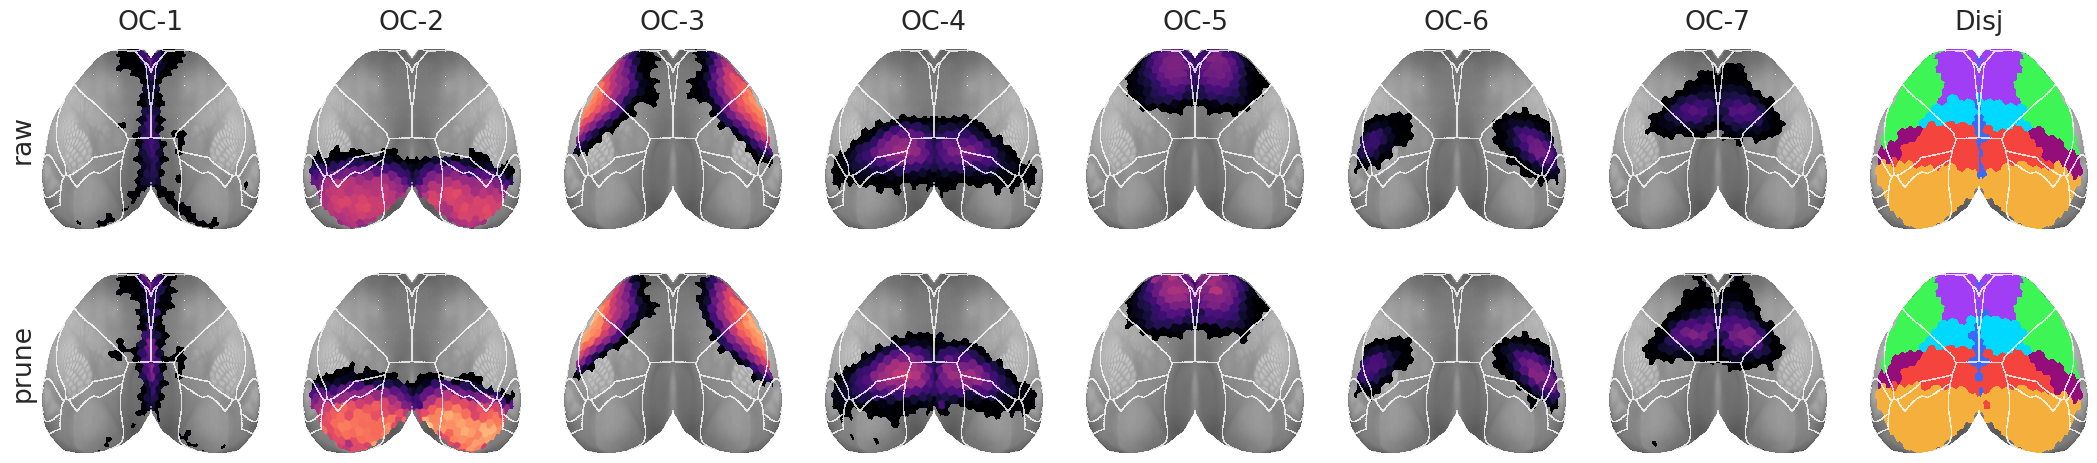

In [7]:
_ = bt.show(
    data={
        'raw': avg(results['bt_dict'][BOLD].run_pi),
        'prune': avg(results['bt_dict'][BOLD].pi_prune)},
    **show_kws(num_k),
)

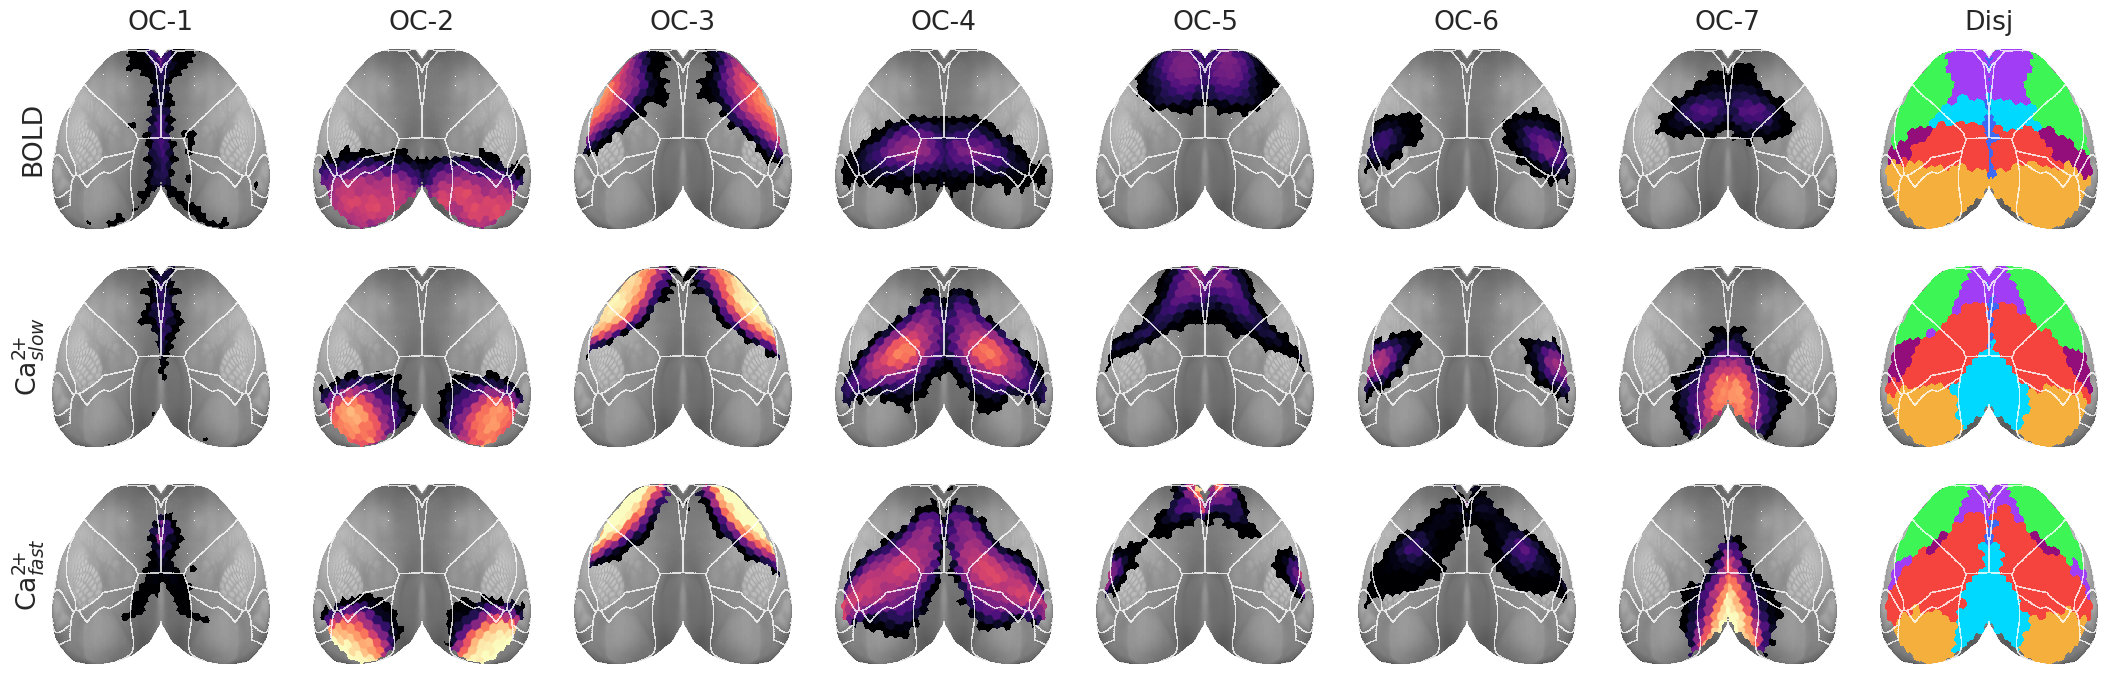

In [8]:
_ = bt.show(
    data={
        mode: avg(o.run_pi) for mode, o
        in results['bt_dict'].items()},
    **show_kws(num_k),
)

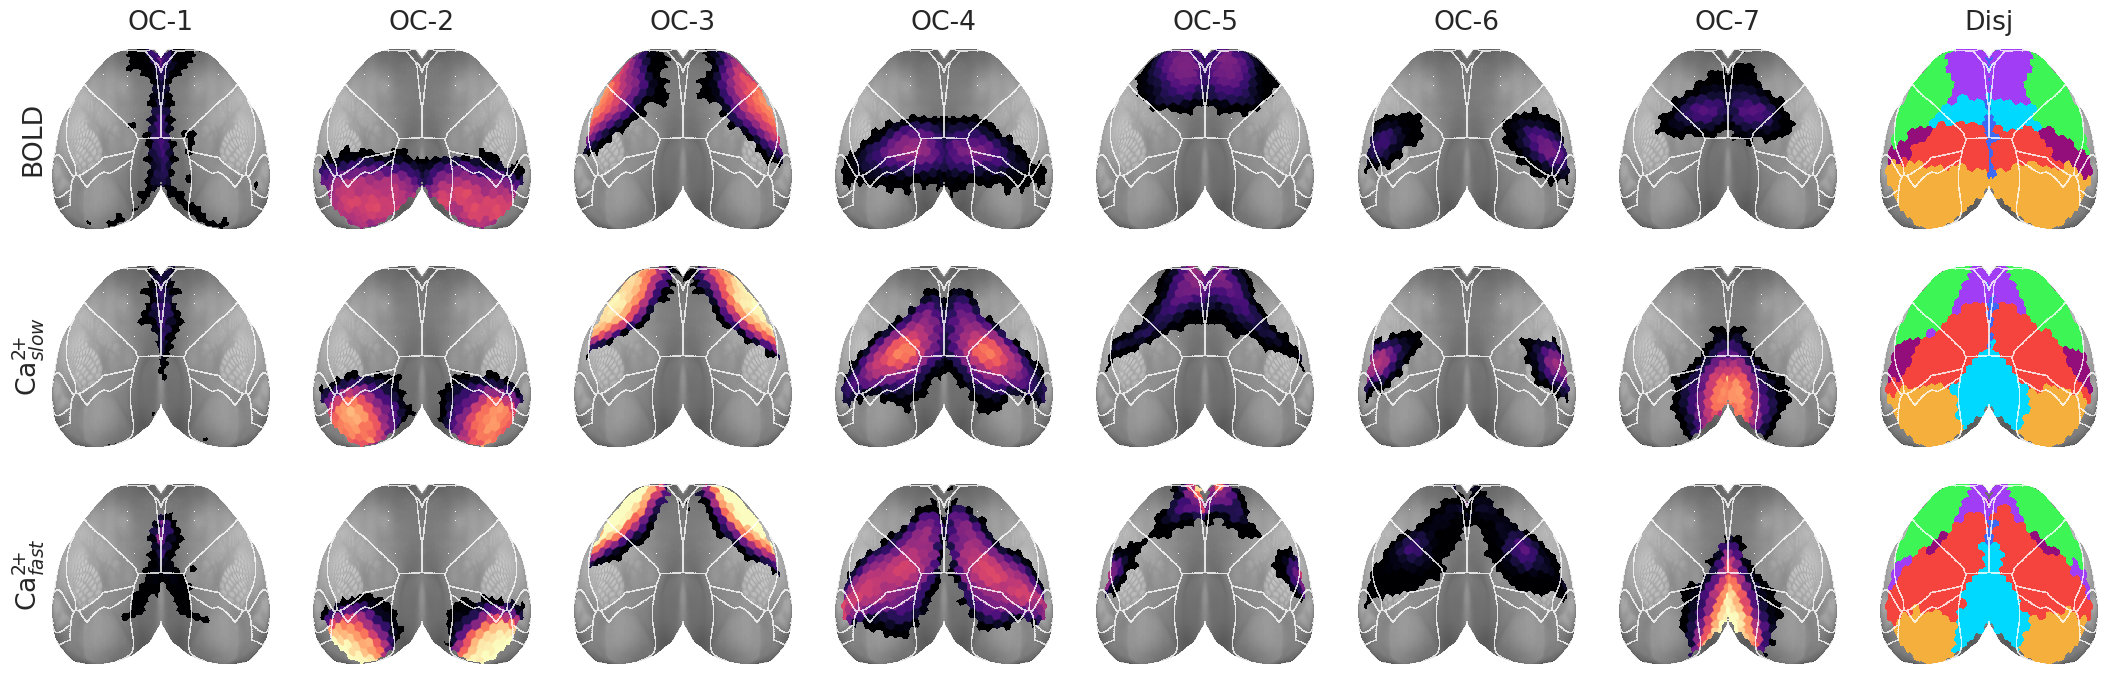

In [9]:
_ = bt.show(results['pi_sorted'], **show_kws(num_k))

### Save Cols & Indiv components

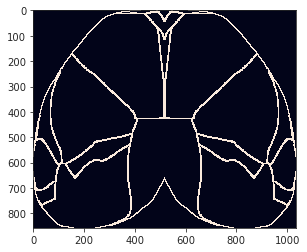

In [10]:
contour = bt.get_contour(0.2, True)
plt.imshow(contour);

In [11]:
from figures.fig_ocs import plot_ocs as go

kwargs = {
    'base': bt,
    'vmin': 0.2,
    'vmax': 0.9,
    'cbar': False,
    'cmap': 'magma',
    'contour': contour,
    'contour_alpha': 0.8,
    'interp': 'antialiased',
    'mask_thres': 1 / num_k,
}
go(
    results['pi_sorted'],
    save_dir=save_dir,
    kws_fig=kws_fig,
    mode2lbl={
        BOLD: 'BOLD',
        CAS: 'CAS',
        CAF: 'CAF'},
    **kwargs,
)

## Similarity plots

### Plot heatmap

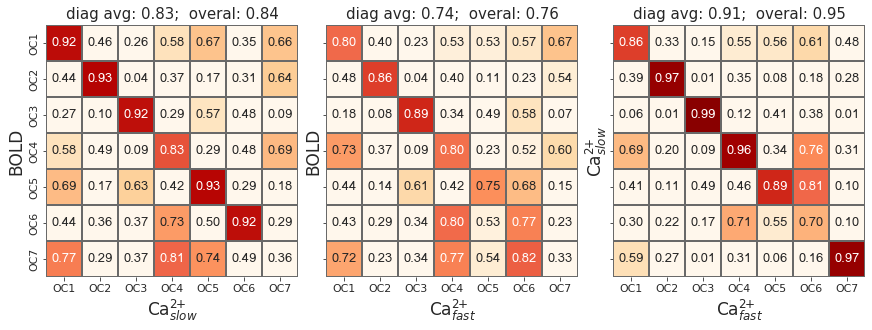

In [12]:
from figures.fig_ocs import similiarity_heatmap as go
_ = go(results['sim'], results['sim_overall'], True, True)
fig, _ = go(results['sim'], results['sim_overall'], False, False)

fig.savefig(pjoin(save_dir, 'sim_hm.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_hm.png'), **kws_fig)

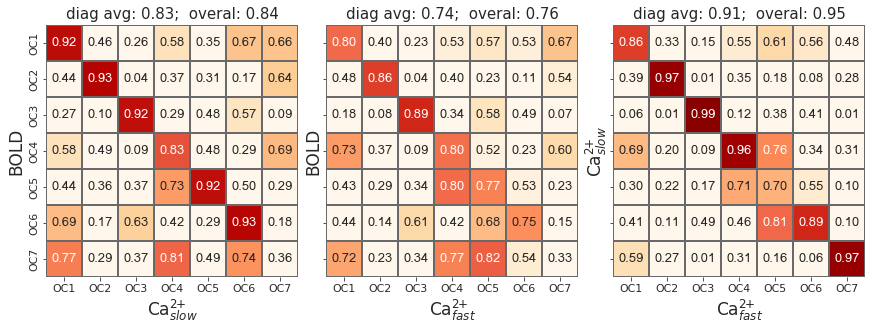

### Plot line

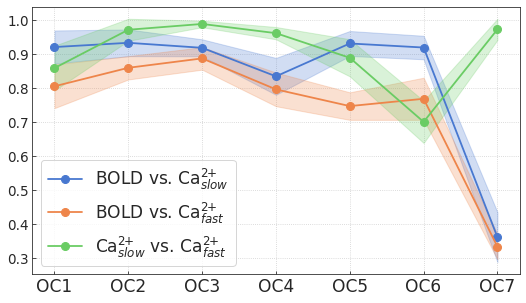

In [13]:
from figures.fig_ocs import similiarity_line as go
fig, _ = go(results['sim'], results['sim_b'], True)

fig.savefig(pjoin(save_dir, 'sim_ln.pdf'), **kws_fig)
fig.savefig(pjoin(save_dir, 'sim_ln.png'), **kws_fig)

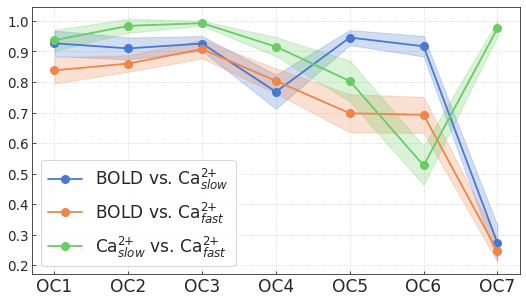

### Look at boot stuff

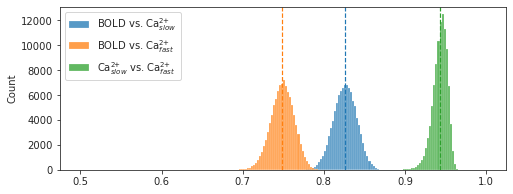

In [14]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['sim_overall_b'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.5, 1, 201),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.2)
ax.legend()
plt.show()

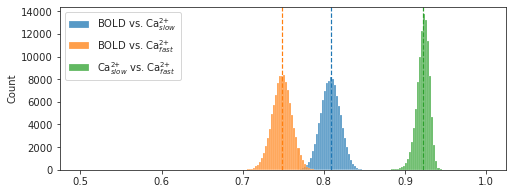

In [15]:
for k, v in results['sim_overall_b'].items():
    se = np.nanstd(v, 0, ddof=1)
    print(k, se, np.round(se * get_tval(), 3))

('BOLD', 'Ca$^{2\\!\\!+}_{slow}$')
0.01423714665509289 0.032

('BOLD', 'Ca$^{2\\!\\!+}_{fast}$')
0.014224385876351966 0.032

('Ca$^{2\\!\\!+}_{slow}$', 'Ca$^{2\\!\\!+}_{fast}$')
0.008763042465426503 0.02

### Perm test

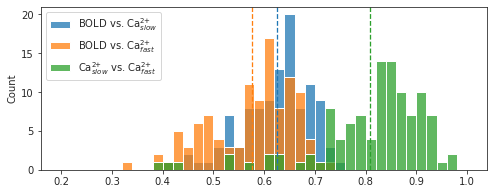

In [16]:
fig, ax = create_figure(1, 1, (8, 3))
for i, ((lbl_1, lbl_2), x) in enumerate(results['data4perm'].items()):
    sns.histplot(
        data=x,
        bins=np.linspace(0.2, 1, 41),
        label=f"{lbl_1} vs. {lbl_2}",
        color=f"C{i}",
        ax=ax,
    )
    ax.axvline(x.mean(), color=f"C{i}", ls='--', lw=1.3)
ax.legend()
plt.show()

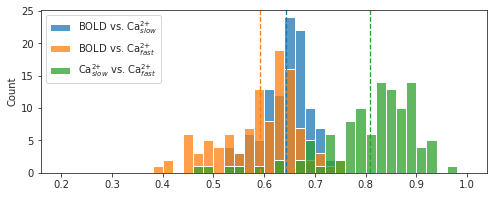

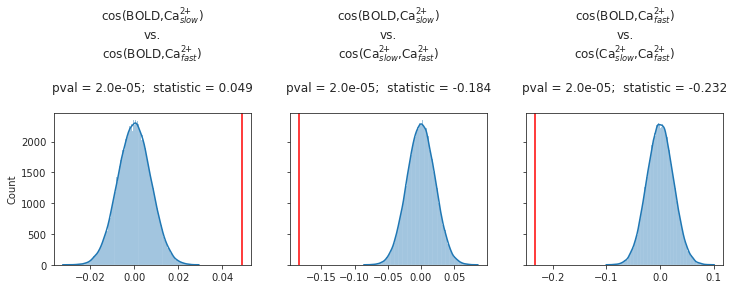

In [17]:
fig, axes = create_figure(1, 3, (12, 2.8), sharey='all')

for i, ((cond_1, cond_2), test) in enumerate(results['tests'].items()):
    ax = axes[i]   
    sns.histplot(test.null_distribution, kde=True, ax=ax)
    ax.axvline(test.statistic, color='r')
    title = f"cos({cond_1[0]},{cond_1[1]})\nvs.\ncos({cond_2[0]},{cond_2[1]})\n\n"
    title += f"pval = {test.pvalue:1.1e};  statistic = {test.statistic:.3f}\n"
    ax.set_title(title)
plt.show()

In [19]:
multipletests([2e-5] * 3, alpha=0.05, method='bonferroni')[0]

array([ True,  True,  True])